In [20]:
import torch 
import torch.nn as nn
from PIL import Image
from  torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [21]:
#lets import an img to use to test our model is structured proparly
f_img = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/images/train/0a0d7a87378422e3.jpg'
f_label = '/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/train/0a0d7a87378422e3.txt'

image = Image.open(f_img)

# normalizes 0 to 1
transform = transforms.ToTensor()
img_tensor = transform(image) 

with open(f_label, 'r') as f:
    label = f.readline().strip()  
    bbox = torch.tensor([float(x) for x in label.split()])

print("Image tensor shape:", img_tensor.shape)
print("Label tensor:", bbox)

Image tensor shape: torch.Size([3, 1024, 683])
Label tensor: tensor([0.0000, 0.5076, 0.3823, 0.5736, 0.5206])


In [22]:
#same bacuise we go 3x3, 3x3, 3x3
class BasicBlockSame(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)

        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


In [23]:
#varying bacuise we go 3x3, 1x1, 3x3
class BasicBlockVarying(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1 ):
        super().__init__()
        self.conv0 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride, bias=False)
        self.bnorm0 = nn.BatchNorm2d(out_channels)

        self.conv1 = nn.Conv2d(out_channels, out_channels, 1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        self.shortcut  = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride)

    def forward(self, x):
        residual = x
        x = self.conv0(x)
        x = self.bnorm0(x)
        x = nn.functional.relu(x)

        x = self.conv1(x)
        x = self.bnorm1(x)
        x = nn.functional.relu(x)

        x = self.conv2(x)
        x = self.bnorm2(x)



        x += self.shortcut(residual)
        x = nn.functional.relu(x)
        return x


In [24]:
class SENBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.sq = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(in_channels, int(in_channels/r))
        self.fc1 = nn.Linear(int(in_channels/r), in_channels)

    def forward(self, x):
        residual = x
        batch_size, channels, _, _ = residual.size()
        x = self.sq(x).squeeze()
        x = self.fc0(x)
        x = nn.functional.relu(x)

        x = self.fc1(x)
        x = nn.functional.sigmoid(x).view(batch_size, channels, 1, 1)
        
        x = residual * x
        return x

In [25]:
class SenResNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.c0 = nn.Conv2d(3,32,3,padding=1)
        self.maxp = nn.MaxPool2d(2,2)
        self.resblock0 = BasicBlockSame(32,64, stride=2)
        self.resblock1 = BasicBlockSame(64,64)
        self.resblock2 = BasicBlockSame(64,64)
        self.sen0 = SENBlock(64)

        self.resblock3  = BasicBlockVarying(64,128, stride=2)
        self.resblock4  = BasicBlockVarying(128,128)
        self.resblock5  = BasicBlockVarying(128,128)
        self.resblock6  = BasicBlockVarying(128,128)
        self.sen1 = SENBlock(128)

        self.resblock7  = BasicBlockVarying(128,256, stride=2)
        self.resblock8  = BasicBlockVarying(256,256)
        self.resblock9  = BasicBlockVarying(256,256)
        self.resblock10  = BasicBlockVarying(256,256)
        self.resblock11  = BasicBlockVarying(256,256)
        self.resblock12  = BasicBlockVarying(256,256)
        self.sen2 = SENBlock(256)

        self.resblock13 = BasicBlockVarying(256,512, stride=2)
        self.resblock14  = BasicBlockVarying(512,512)
        self.resblock15 = BasicBlockVarying(512,512)

        self.c1 = nn.Conv2d(512, 1024, 3, padding=1 , stride=2)
        self.c2 = nn.Conv2d(1024, 512, 1, padding=1)
        self.gap0 = nn.AdaptiveAvgPool2d(1)
        self.fc0 = nn.Linear(512, 4)



    def forward(self, x):
        x = self.c0(x)
        x = self.maxp(x)

        x = self.resblock0.forward(x)
        x = self.resblock1.forward(x)
        x = self.resblock2.forward(x)
        x = self.sen0.forward(x)

        x = self.resblock3.forward(x)
        x = self.resblock4.forward(x)
        x = self.resblock5.forward(x)
        x = self.resblock6.forward(x)
        x = self.sen1.forward(x)

        x = self.resblock7.forward(x)
        x = self.resblock8.forward(x)
        x = self.resblock9.forward(x)
        x = self.resblock10.forward(x)
        x = self.resblock11.forward(x)
        x = self.resblock12.forward(x)
        x = self.sen2.forward(x)

        x = self.resblock13.forward(x)
        x = self.resblock14.forward(x)
        x = self.resblock15.forward(x)
        
        x = self.c1(x)
        x = self.c2(x)
        x = self.gap0(x).squeeze()
        x = self.fc0(x)


        return x

In [26]:
model = SenResNet()

In [27]:
img_tensor  = img_tensor.unsqueeze(dim=0)

In [28]:
res  = model(img_tensor)
res.shape

torch.Size([4])

model works for the forward pas lets train

In [29]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
bbox[1:]

tensor([0.5076, 0.3823, 0.5736, 0.5206])

In [31]:
device = 'mps'
img_tensor = img_tensor.to(device)
model = model.to(device)
bbox = bbox.to(device)

In [32]:
lossi = []

In [101]:
logits = model(img_tensor)
loss = criterion(logits, bbox[1:])
optimizer.zero_grad()
loss.backward()
optimizer.step()

lossi.append(loss.item())


([<matplotlib.lines.Line2D at 0x11a12e270>], 0.002652724040672183)

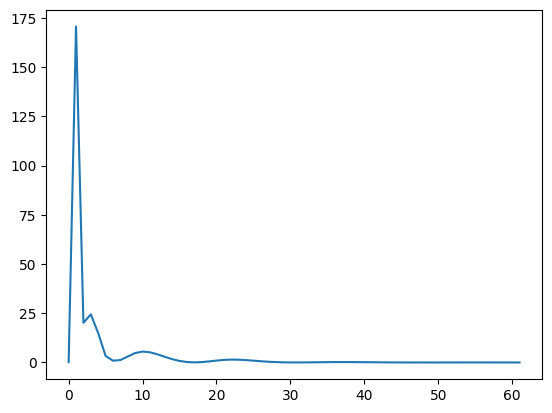

In [102]:
plt.plot(lossi), lossi[-1]

In [103]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[0]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[1]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[2] / 2))
    half_height = int(len(im) * (bbox_pred[3] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }

def visualize_prediction(img_tensor, bbox_pred, epoch):
    im = img_tensor.squeeze(0).permute(1, 2, 0).numpy()
    
    center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox_pred)
    coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred)
    
    plt.imshow(im)
    plt.plot(center_x_pxl, center_y_pxl, 'ro')
    
    # horizontal lines
    plt.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    plt.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
    
    # vertical lines
    plt.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
    plt.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
    
    plt.title(f'Epoch {epoch}')
    plt.show()

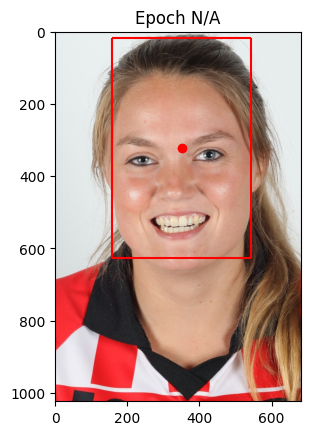

In [104]:
visualize_prediction(img_tensor.cpu(), logits.cpu(), 'N/A')